In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X = np.load('combined.npy')
y = np.load('segmented.npy')

In [3]:
print(X.shape, y.shape)

(2000, 64, 84) (2000, 64, 84, 10)


In [4]:
#Shuffle
indices = list(range(len(X)))
np.random.shuffle(indices)

X = X[indices].astype(np.float32)
y = y[indices].astype(np.float32)

In [6]:
# Normalize (Needed?)
X -= 127.0
X /= 127.0

y  -= 127.0
y /= 127.0

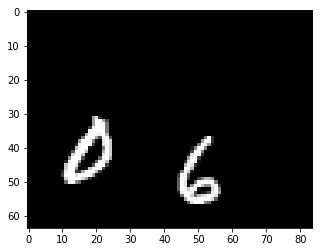

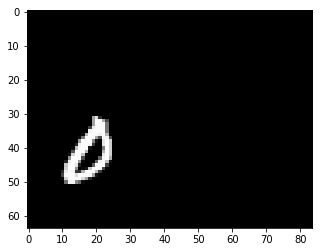

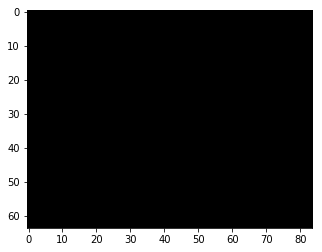

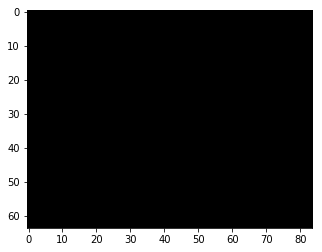

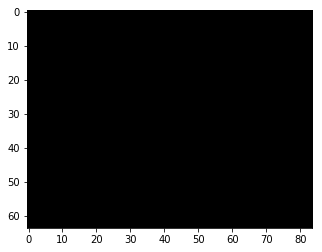

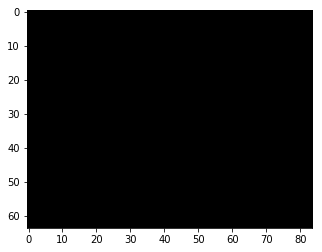

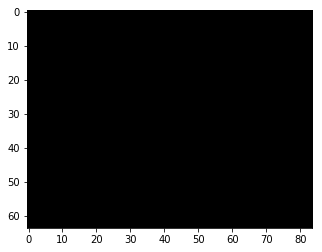

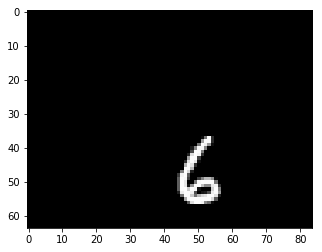

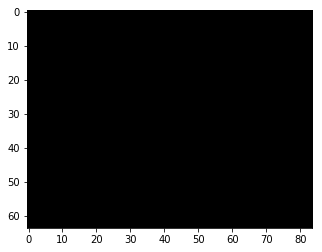

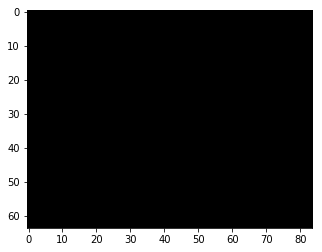

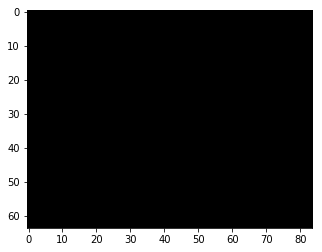

In [8]:
rand_index = np.random.randint(0,len(y))
c,s = X[rand_index], y[rand_index]

plt.imshow(c, cmap='gray')
plt.show()

for i in range(10):
    plt.imshow(s[:,:,i],cmap='gray')
    plt.show()

In [9]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]


In [10]:
def get_next_batch(batch_size, X, y):
    for i in range(0,len(y),batch_size):
        start = i
        end = min(len(y), i+batch_size)
        yield X[start:end, :] , y[start:end]

In [11]:
num_classes = 10

In [12]:
def nn():
    img_placeholder = tf.placeholder(dtype=tf.float32, shape=(None, X.shape[1],X.shape[2]), name='input_image')
    labels = tf.placeholder(dtype=tf.int32, shape=(None, y.shape[1], y.shape[2], y.shape[3]), name='labels')
    learning_rate_ph = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    input_2d = tf.reshape(img_placeholder,[-1,28,28,1], name='reshaped_image')
    l1_1 = tf.layers.conv2d(input_2d,8,5,1,activation=tf.nn.relu, name='conv1')
    l1_2 = tf.layers.max_pooling2d(l1_1,2,2,name='pool1')
    l1_3 = tf.layers.conv2d(l1_2,8,3,1,activation=tf.nn.relu,name='conv2')
    l1_4 = tf.layers.max_pooling2d(l1_3,2,2,name='poool2/Maxpool:0')
    
     _conv1x1 = lambda tensor :\
     tf.layers.conv2d(tensor, 
                    num_classes, 
                    1, 
                    1, 
                    padding='same',
                    kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
        
    _upsample = lambda tensor, kernel_sz, stride :\
     tf.layers.conv2d_transpose(tensor, 
                                num_classes, 
                                kernel_sz, 
                                stride, 
                                padding='same',
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))
    l2_1 = _upsample(_conv1x1(l1_4),4,2)
    l1_5 = tf.layers.flatten(l1_4, name='flatten')
    l2   = tf.layers.dense(l1_5, 32, activation=tf.nn.relu,name='dense32')
    out  = tf.layers.dense(l2,10,name='dense10')
    predictions = tf.identity(out, name='predictions')
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(labels,depth=10)), name='cost')
    
    # Apply an optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
    return img_placeholder, labels, learning_rate_ph, cost, optimizer, predictions

IndentationError: unexpected indent (<ipython-input-12-2b1ee9ee3146>, line 12)

In [ ]:
img_placeholder, labels, learning_rate_ph, cost, optimizer, output = nn()

In [ ]:
def eval_cost(cost_op, X, y, batch_sz):
    total_cost = 0
    nb_batches = 0
    for batch_X,batch_y in get_next_batch(batch_size,X,y):
        feed_dict={img_placeholder: batch_X, labels: batch_y}
        total_cost += cost.eval(feed_dict=feed_dict)
        nb_batches += 1
    return total_cost / nb_batches

def eval_accuracy(output_op, X, y, batch_sz):
    nb_batches = 0
    total_acc = 0
    for batch_X, batch_y in get_next_batch(batch_sz,X,y):
        feed_dict={img_placeholder: batch_X, labels: batch_y}
        y_predicted = np.argmax(output.eval(feed_dict=feed_dict),1)
        total_acc += accuracy_score(batch_y,y_predicted)
        nb_batches += 1
    return 100*total_acc/nb_batches

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

epochs = 75
batch_size = 512
learning_rate = 0.001
batches_per_epoch = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)



# Launch the graph
with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter('./',sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(epochs)):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        

        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all training batches
        for x, y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, 
                     feed_dict={img_placeholder:x, labels:y, learning_rate_ph:learning_rate})
        
        if (epoch+1) % 5 == 0:
            training_cost = eval_cost(cost, X_train_fold, y_train_fold, batch_size)
            training_acc  = eval_accuracy(output, X_train_fold, y_train_fold, batch_size)
            valid_acc  = eval_accuracy(output, X_val_fold, y_val_fold, batch_size)
            test_acc  = eval_accuracy(output, X_test, y_test, batch_size)
            #print(training_cost, training_acc, valid_acc, test_acc)
            
            summary = tf.Summary()
            summary.value.add(tag="Train Cost", simple_value=training_cost)
            summary.value.add(tag="Train Accuracy", simple_value=training_acc)
            summary.value.add(tag="Validation Accuracy", simple_value=valid_acc)
            summary.value.add(tag="Test Accuracy", simple_value=test_acc)
            summary_writer.add_summary(summary,epoch+1)
            summary_writer.flush()

    
    print("Optimization Finished!")
    summary_writer.close()
    # Save the graph structure only.
    # Need to save weights in a checkpoint file separately.
    # The graph structure is saved twice, once as a text file 
    # with extension '.pbtxt' and then as a binary file with 
    # extension '.pb'. This is done for demonstration only.
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist.pbtxt',
    as_text=True)
    
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist.pb',
    as_text=False)
    
    saver = tf.train.Saver()
    saver.save(sess,'./checkpoints/mnist.ckpt',epoch+1)